In [61]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import display
from PIL import Image
from random import randint
from time import sleep
from torch import Tensor
from torch.nn.modules.loss import CrossEntropyLoss, _Loss
from torch.optim.optimizer import Optimizer
from torch.optim.sgd import SGD
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms.transforms import Compose, Normalize, ToTensor
from typing import List

In [2]:
# Device configuration
device: str = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device...")

Using cuda device...


In [21]:
transform: Compose = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5,))])

# CIFAR-10 dataset
train_dataset: CIFAR10 = CIFAR10(
    root="./data", train=True, transform=transform, download=True
)
test_dataset: CIFAR10 = CIFAR10(
    root="./data", train=False, transform=transform, download=True
)

class_names: List[str] = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Files already downloaded and verified
Files already downloaded and verified


Id: 39041 - Class: truck


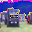

Id: 31770 - Class: bird


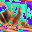

Id: 44293 - Class: dog


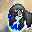

Id: 6912 - Class: ship


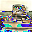

Id: 25993 - Class: automobile


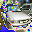

In [35]:
def display_img_with_idx(idx: int) -> None:
    img: Tensor = train_dataset.__getitem__(idx)[0]
    cls: int = class_names[train_dataset.__getitem__(idx)[1]]

    if img.is_cuda:
        img = img.cpu()

    img_arr: np.ndarray = img.numpy().transpose(1, 2, 0)
    if img_arr.max() <= 1:
        img_arr = (img_arr * 255).astype(np.uint8)
    if img_arr.shape[2] == 1:
        img_arr = img_arr.squeeze(axis=2)

    img_pil: Image = Image.fromarray(img_arr)
    
    print(f"Id: {idx} - Class: {cls}")
    sleep(1)
    display(img_pil)


for _ in range(5):
    display_img_with_idx(randint(0, len(train_dataset)))

In [67]:
# Hyper-parameters
num_epochs: int = 20
batch_size: int = 64
learning_rate: float = 0.001

train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1: nn.Sequential = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2: nn.Sequential = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1: nn.Linear = nn.Linear(8 * 8 * 32, 512)
        self.fc2: nn.Linear = nn.Linear(512, 128)
        self.fc3: nn.Linear = nn.Linear(128, 10)
    

    def forward(self, x: Tensor) -> Tensor:
        out: Tensor = self.layer1(x)
        out: Tensor = self.layer2(out)
        out: Tensor = out.view(out.size(0), -1)
        out: Tensor = F.relu(self.fc1(out))
        out: Tensor = F.relu(self.fc2(out))
        out: Tensor = self.fc3(out)
        
        return out
    
model: ConvNet = ConvNet().to(device)
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [68]:
loss_fn: CrossEntropyLoss = CrossEntropyLoss()
optimizer: SGD = SGD(model.parameters(), lr=learning_rate)

In [69]:
def train(
    dataloader: DataLoader, model: nn.Module, loss_fn: _Loss, optimizer: Optimizer
) -> None:
    size: int = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X: Tensor
        y: Tensor
        X, y = X.to(device), y.to(device)

        pred: Tensor = model(X)
        loss: Tensor = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            current: int = (batch + 1) * len(X)
            loss: float = loss.item()
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

def test(dataloader: DataLoader, model: nn.Module, loss_fn: _Loss) -> None:
    size: int = len(dataloader.dataset)
    num_batches: int = len(dataloader)

    model.eval()
    test_loss: float = 0.0
    correct: float = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X: Tensor
            y: Tensor
            X, y = X.to(device), y.to(device)

            pred: Tensor = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n\tAccuracy: {(100 * correct):>4f}% \n\tAvg loss: {test_loss:>8f} \n"
    )

In [70]:
for _ in range(num_epochs):
    print(f"Epoch {_ + 1} \n{'-' * 100}")

    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1 
----------------------------------------------------------------------------------------------------
loss: 2.299456  [   64/50000]
loss: 2.267129  [ 6464/50000]
loss: 2.267429  [12864/50000]
loss: 2.235705  [19264/50000]
loss: 2.258457  [25664/50000]
loss: 2.209637  [32064/50000]
loss: 2.200819  [38464/50000]
loss: 2.204052  [44864/50000]
Test Error: 
	Accuracy: 30.280000% 
	Avg loss: 2.140996 

Epoch 2 
----------------------------------------------------------------------------------------------------
loss: 2.164827  [   64/50000]
loss: 2.101759  [ 6464/50000]
loss: 2.077687  [12864/50000]
loss: 2.056447  [19264/50000]
loss: 2.019895  [25664/50000]
loss: 2.032206  [32064/50000]
loss: 1.935727  [38464/50000]
loss: 2.043091  [44864/50000]
Test Error: 
	Accuracy: 34.570000% 
	Avg loss: 1.934125 

Epoch 3 
----------------------------------------------------------------------------------------------------
loss: 1.946388  [   64/50000]
loss: 1.859437  [ 6464/50000]
loss: 1.950293